In [35]:
from datetime import datetime
import time
import pickle
import glob
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from scipy.stats import randint, uniform
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import StratifiedShuffleSplit
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.util import pad
from tensorflow.python.framework.ops import reset_default_graph

from util import etl, helpers, cnn_classifier

In [31]:
heights, widths = [None,] * len(IMAGE_PATHS), [None,] * len(IMAGE_PATHS)
for i, path in enumerate(IMAGE_PATHS):
    image = imread(path)
    h, w = image.shape
    heights[i] = h
    widths[i] = w
print np.max(heights), np.max(widths)

1089 1706


(513, 1706)


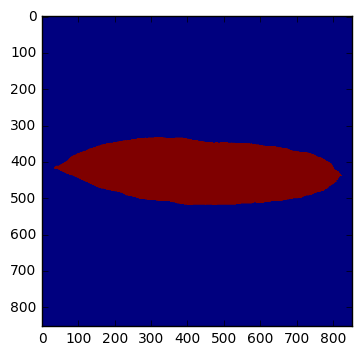

In [116]:
def pad_upto(image, (target_height, target_width)):
    h, w = image.shape
    up, left = (target_height - h) / 2, (target_width - w) / 2
    down, right = target_height - h - up, target_width - w - left
    return pad(image, ((up, down), (left, right)), 'constant')

def resize_proportionally(image, (target_height, target_width)):
    h, w = image.shape
    h_mul, w_mul = target_height / float(h), target_width / float(w)
    if h_mul > w_mul:
        scaled = resize(image, (int(w_mul * h), target_width), mode='constant')
        print scaled.shape
    else:
        scaled = resize(image, (target_height, int(h_mul * w)), mode='constant')
    return pad_upto(scaled, (target_height, target_width))

def scale_resize(image, (max_height, max_width), (target_height, target_width)):
    return resize(resize_proportionally(image, (max_height, max_width)), (target_height, target_width))

resized = scale_resize(image, (1706, 1706), (853, 853))
plt.imshow(np.round(resized))
plt.show()

(579, 446)
(1706, 1706)


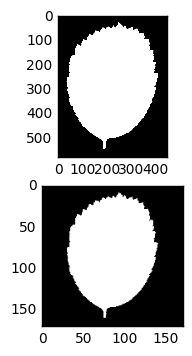

(286, 950)
(513, 1706)
(1706, 1706)


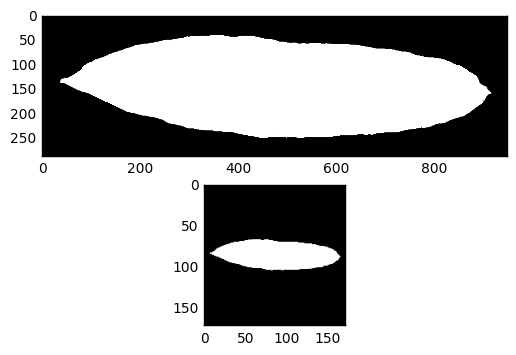

In [103]:
IMAGE_PATHS = glob.glob("./data/images/*.jpg")


for path in IMAGE_PATHS[300:302]:
    image = imread(path, as_grey=True)
    print image.shape
    resized = resize_proportionally(image, (1706, 1706))
    plt.subplot(211)
    plt.imshow(image, cmap='gray')
    plt.subplot(212)
    plt.imshow(resize(resized, (171, 171)), cmap='gray')
    print resized.shape
    plt.show()


In [5]:
TRAIN_PATH = "./data/train.csv"
TEST_PATH = "./data/test.csv"
IMAGE_PATHS = glob.glob("./data/images/*.jpg")

with open('./data/train.pickle', 'rb') as f:
    train = pickle.load(f)
with open('./data/test.pickle', 'rb') as f:
    test = pickle.load(f)
with open('./data/le.pickle', 'rb') as f:
    classes = pickle.load(f)
    
BATCH_SIZE = 64
NUM_CLASSES = 99
ITERATIONS = 1e3
SEED = 42
TRAIN_SIZE = 1.0
VALIDATION_SIZE = 0.1
CLASS_SIZE = 0.1

In [6]:
params = {
    'conv1_num': 5,
    'conv1_out': 32,
    'conv2_num': 5,
    'conv2_out': 64,
    'd_out': 1024,
    'dropout': 0.75,
    'HEIGHT': 128,
    'WIDTH': 128,
    'CHANNEL': 1,
    'BATCH_SIZE': 64,
    'NUM_CLASSES': 99,
    'VALIDATION_SIZE': VALIDATION_SIZE,
    'SEED': SEED,
    'TRAIN_SIZE': TRAIN_SIZE,
    'CLASS_SIZE': 0.1,
    'ITERATIONS': ITERATIONS,
    'LEARNING_RATE': 0.0005,
    'report_interval': 1
}
model = cnn_classifier.CnnClassifier(train, test, classes, params)
model.train(1)

initiating batch generator with (10/99) classes and 1.000000 of the training data and 0.100000 as validation
(64, 128, 128, 32)
(64, 64, 64, 32)
(64, 64, 64, 64)
(64, 32, 32, 64)
(64, 1024)
(64, 10)
Iter 	 Batch Loss 	 Batch Accuracy 	 Valid Loss 	 Valid Accuracy 	 Time delta

0	239193.3750		0.1094		41435.6016		0.0312		20.6415

594 594
1	219900.4375		0.0156		31952.4570		0.0312		11.4365

594 594
deleted results at ./tmp/results/results_41435.601562_0_2017-01-24T18:48:15.920818.csv


In [27]:
def random_search(params_range, samplings, iterations=1e8):
    for instance in range(samplings):
        params = {}
        for param_name, value in params_range.items():
            if type(value) == tuple:
                base, dist = value
                if base == 0:
                    params[param_name] = dist.rvs()
                else:
                    params[param_name] = base ** dist.rvs()
            else:
                params[param_name] = value
        print json.dumps(params, indent=2)
        #model = cnn_classifier.CnnClassifier(train, test, classes, params)
        #model.train(iterations)

In [32]:
params_range = {
    'conv1_num': (0, randint(1, 10)),
    'conv1_out': (2, randint(2, 8)),
    'conv2_num': (0, randint(1, 10)),
    'conv2_out': (2, randint(2, 8)),
    'd_out': (2, randint(4, 10)),
    'dropout': (0, uniform(0, 1.0)),
    'HEIGHT': 128,
    'WIDTH': 128,
    'CHANNEL': 1,
    'BATCH_SIZE': 64,
    'NUM_CLASSES': 99,
    'VALIDATION_SIZE': VALIDATION_SIZE,
    'SEED': SEED,
    'TRAIN_SIZE': TRAIN_SIZE,
    'CLASS_SIZE': 0.1,
    'ITERATIONS': ITERATIONS,
    'LEARNING_RATE': (10, randint(-6, 1)),
    'report_interval': 1
}
random_search(params_range, 5)

{
  "VALIDATION_SIZE": 0.1, 
  "conv2_num": 5, 
  "report_interval": 1, 
  "conv2_out": 64, 
  "dropout": 0.74683366281846841, 
  "CHANNEL": 1, 
  "BATCH_SIZE": 64, 
  "HEIGHT": 128, 
  "TRAIN_SIZE": 1.0, 
  "WIDTH": 128, 
  "SEED": 42, 
  "d_out": 64, 
  "NUM_CLASSES": 99, 
  "ITERATIONS": 1000.0, 
  "conv1_num": 6, 
  "LEARNING_RATE": 0.1, 
  "CLASS_SIZE": 0.1, 
  "conv1_out": 128
}
{
  "VALIDATION_SIZE": 0.1, 
  "conv2_num": 9, 
  "report_interval": 1, 
  "conv2_out": 32, 
  "dropout": 0.18888091641438898, 
  "CHANNEL": 1, 
  "BATCH_SIZE": 64, 
  "HEIGHT": 128, 
  "TRAIN_SIZE": 1.0, 
  "WIDTH": 128, 
  "SEED": 42, 
  "d_out": 256, 
  "NUM_CLASSES": 99, 
  "ITERATIONS": 1000.0, 
  "conv1_num": 4, 
  "LEARNING_RATE": 0.001, 
  "CLASS_SIZE": 0.1, 
  "conv1_out": 32
}
{
  "VALIDATION_SIZE": 0.1, 
  "conv2_num": 9, 
  "report_interval": 1, 
  "conv2_out": 16, 
  "dropout": 0.03818204443454154, 
  "CHANNEL": 1, 
  "BATCH_SIZE": 64, 
  "HEIGHT": 128, 
  "TRAIN_SIZE": 1.0, 
  "WIDTH": 128, 